In [1]:
%load_ext autoreload
%autoreload 2

from deep_bf.data_handler import DataLoader
import torch

dl = DataLoader("/home/panda/rf_data")

#name = "contrast_speckle_expe_dataset_rf"
name = "contrast_speckle_simu_dataset_rf"
#name = "resolution_distorision_expe_dataset_rf"
#name = "resolution_distorision_simu_dataset_rf"
#name = "carotid_cross_expe_dataset_rf"
#name = "carotid_long_expe_dataset_rf"

dl = DataLoader("../../../rf_data")
pw = dl.get_defined_pwdata(name, "RF")

#nz = 1024
#nx = 512
nz = 2048
nx = 256

device = "cuda"
dtype = torch.float32

def get_size(tensor):
    bytes = tensor.nelement() * tensor.element_size()
    print(f"La variable ocupa: {bytes / (1024 ** 2):.2f} MB")
    

In [2]:
from deep_bf.beamformers import compute_d_rx, compute_d_tx, compute_meshgrid
from deep_bf.beamformers import dynamic_receive_aperture
import numpy as np

Z, X = compute_meshgrid(pw, nz, nx, device=device, dtype=dtype)
d_rx = compute_d_rx(pw, Z, X, device=device, dtype=dtype)

angles_idx = np.arange(pw.n_angles)

d_tx, t0 = compute_d_tx(pw, Z, X, angle_indices=angles_idx, device=device, dtype=dtype) # [n_angles, nz, nx]

apod = dynamic_receive_aperture(Z, X, pw.probe_geometry, f_num=1.75, window="tukey25", device=device, dtype=dtype) # [n_elements, nz, nx]

get_size(d_tx)
get_size(d_rx)
get_size(apod)

La variable ocupa: 150.00 MB
La variable ocupa: 256.00 MB
La variable ocupa: 256.00 MB


In [3]:
from deep_bf.beamformers import RFGridSampleDAS, RFInterDAS

batch_size = 8
bf = RFGridSampleDAS(nz, nx, pw, angles_idx, batch_size=batch_size).cuda()
test_name = name + "_GridSampleDAS.png"

#batch_size = 1
#bf = RFInterDAS(nz, nx, pw, angles_idx, batch_size=batch_size).cuda()
#test_name = name + "_InterDAS.png"

with torch.no_grad():
    das_all_angles = bf(d_tx, d_rx, apod)  # [n_angles, nz, nx]

In [5]:
import numpy as np
from deep_bf.beamformers import get_rf_bmode

das_np = das_all_angles.cpu().numpy()
das = das_np.mean(axis=0)

b_mode = get_rf_bmode(das)

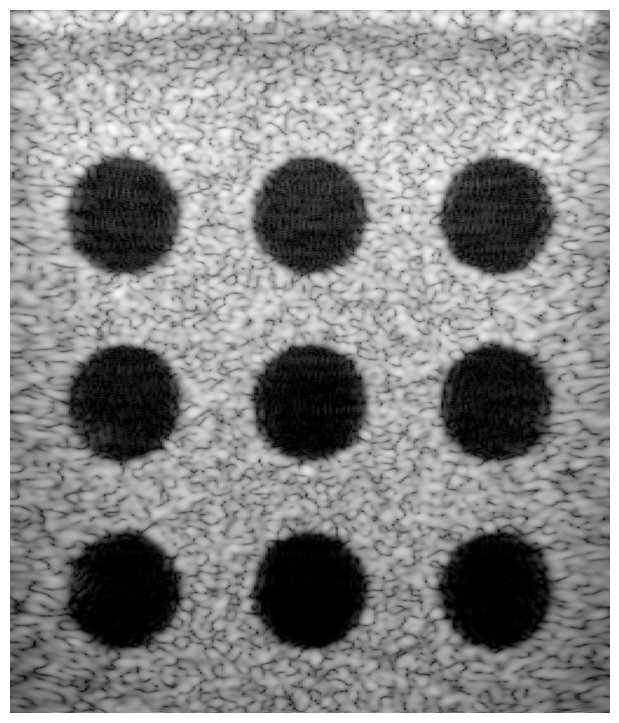

In [6]:
import matplotlib.pyplot as plt
import numpy as np

Z1 = Z.cpu()
X1 = X.cpu()

zlims = np.array([Z1[0, 0], Z1[-1, 0]]) * 1e3
xlims = np.array([X1[0, 0], X1[0, -1]]) * 1e3

# 1. Crea la figura, pero dile que NO dibuje su propio marco (frameon=False)
fig = plt.figure(figsize=(6, 8), frameon=False)

# 2. Crea un eje que ocupe explícitamente toda la figura [left, bottom, width, height]
# Esto es mucho más robusto que subplots_adjust
ax = fig.add_axes([0, 0, 1, 1])

# 3. Muestra la imagen en ese eje
ax.imshow(b_mode, cmap='gray', vmin=-60, vmax=0,
          extent=(xlims[0], xlims[-1], zlims[-1], zlims[0]),
          aspect='equal')

plt.savefig(f"./fig_tests/{test_name}",
            dpi=300,
            bbox_inches='tight',
            pad_inches=0)

# 4. Apaga el eje (elimina ticks, etiquetas, líneas)
ax.set_axis_off()

# 5. Guarda la imagen.
# 'pad_inches=0' es crítico.
# 'facecolor' ya no es estrictamente necesario con frameon=False, pero lo dejamos por seguridad.


# Cierra la figura para liberar memoria si lo usas en un bucle
plt.show()

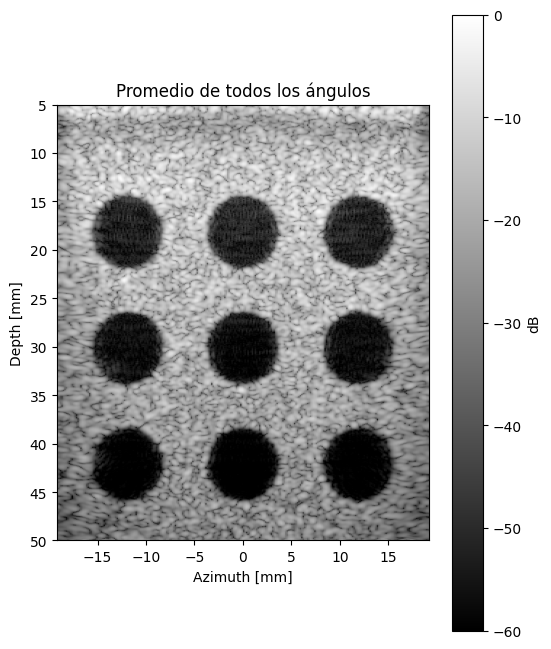

In [7]:
import matplotlib.pyplot as plt

Z1 = Z.cpu()
X1 = X.cpu()

zlims = np.array([Z1[0, 0], Z1[-1, 0]]) * 1e3
xlims = np.array([X1[0, 0], X1[0, -1]]) * 1e3

plt.figure(figsize=(6, 8))
plt.imshow(b_mode, cmap='gray',vmin=-60, vmax=0,
           extent=(xlims[0], xlims[-1], zlims[-1], zlims[0]))
plt.title("Promedio de todos los ángulos")
plt.xlabel("Azimuth [mm]")
plt.ylabel("Depth [mm]")
plt.colorbar(label="dB")

#plt.savefig(f"./fig_tests/{test_name}", dpi=300)

plt.show()



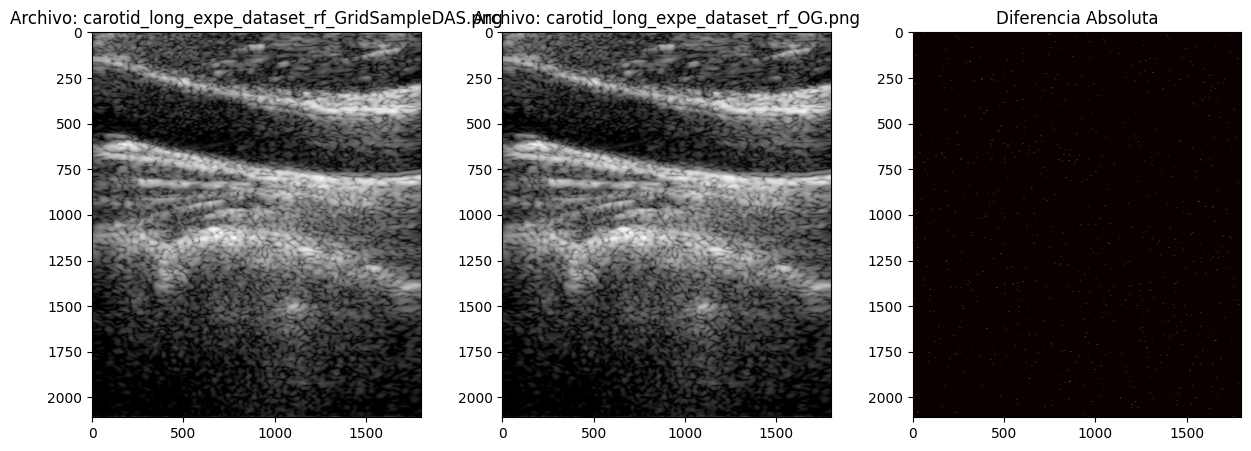

{'mse': np.float32(2.0927866e-08), 'psnr': np.float64(76.75862197983949), 'ssim': np.float64(0.9999898999987077)}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.color import rgb2gray # Opcional, para asegurar conversión

def comparar_pngs(ruta_img1, ruta_img2):
    """
    Lee dos archivos .png, los compara y devuelve los datos en variables.
    """
    img1_raw = mpimg.imread(ruta_img1)
    img2_raw = mpimg.imread(ruta_img2)

    def procesar_canal(img):
        if img.ndim == 3:
            return rgb2gray(img[..., :3])
        return img

    i1 = procesar_canal(img1_raw)
    i2 = procesar_canal(img2_raw)

    rango = max(i1.max(), i2.max()) - min(i1.min(), i2.min())
    mse_v = np.mean((i1 - i2) ** 2)
    psnr_v = psnr(i1, i2, data_range=rango)
    ssim_v = ssim(i1, i2, data_range=rango)

    metrics = {"mse": mse_v, "psnr": psnr_v, "ssim": ssim_v}

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(i1, cmap='gray')
    axes[0].set_title(f"Archivo: {ruta_img1.split('/')[-1]}")
    
    axes[1].imshow(i2, cmap='gray')
    axes[1].set_title(f"Archivo: {ruta_img2.split('/')[-1]}")
    
    diff = np.abs(i1 - i2)
    axes[2].imshow(diff, cmap='hot')
    axes[2].set_title("Diferencia Absoluta")
    
    plt.show()
    return metrics, i1, i2

ruta1 = "/home/panda/code/usm/deep_bf/fig_tests/carotid_long_expe_dataset_rf_GridSampleDAS.png"
ruta2 = "/home/panda/code/usm/deep_bf/fig_tests/carotid_long_expe_dataset_rf_InterDAS.png"
ruta3 = "/home/panda/code/usm/deep_bf/fig_tests/carotid_long_expe_dataset_rf_OG.png"
stats, data_tf, data_pt = comparar_pngs(ruta1, ruta3)

print(stats)